# Maximize the number of 1s (One Max Problem)

In [13]:
import random
from typing import List, Tuple, Callable
import logging
from enum import Enum
from tqdm import tqdm
import matplotlib.pyplot as plt

class VariationOperator(Enum):
    MUTATION = 1
    CROSSOVER = 2

log_level = logging.INFO
logging.basicConfig(level=log_level, format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger(__name__).setLevel(log_level)

class OneMax:
    def __init__(self, dim: int=10, population_size: int=100, optimize: bool = False, has_heuristic: bool = False):
        """
        initializes the OneMax evolutionary algorithm.
        can be initialized with an enhanced (optimized) population.
        """
        self.__has_heuristic = has_heuristic
        self.__best_scores: List[int] = []
        self.__worst_scores: List[int] = []
        
        logging.info(f"starting initialization of {population_size} samples of size {dim}")
        self.__population: List[List[int]] = []
        for _ in tqdm(range(population_size), desc="Initializing Population..."):
            s = self.__get_random_sample(dim=dim)
    
            # optional (initialize with an enhanced population)
            if optimize:
                # logging.info(f"enhancing {s} ({self.fitness(s)}) to...")
                s = self.__enhance(s=s, fitness_fn=self.__fitness, neighbors_fn=self.__get_neighbors)
                # logging.info(f"{enhanced_s} ({self.fitness(enhanced_s)}) \n")
                
            self.__population.append(s)

        logging.info(f"initialization complete!")
    
    def __get_random_sample(self, dim: int=10) -> List[int]:
        return [random.choice([0, 1]) for _ in range(dim)]
    
    def __enhance(self, s: List[int], fitness_fn: Callable[[List[int]], int],
                   neighbors_fn: Callable[[List[int]], List[List[int]]], is_greedy: bool = True) -> List[int]:
        """
        enhances the input s based on a given fitness function by search in a 
        neighboring space produced by the neighbors_fn. 
        returns the first better solution if is_greedy is True.
        """
        best_score = fitness_fn(s)
        best = s
    
        ns = neighbors_fn(s)
        for n in ns:
            # logging.info("searching...")
            n_score = fitness_fn(n)
            if n_score > best_score:
                best_score = n_score
                best = n
                if is_greedy:
                    return best
    
        return best
    
    def __fitness(self, s: List[int]) -> int:
        return sum(s)

    def __get_neighbors(self, s: List[int]) -> List[List[int]]:
        """
        get_neighbors return a list of neighboring points each of which 
        obtained by flipping one of the bits
        """
        neighbors: List[List[int]] = []
        for i in range(len(s)):
            s2 = s.copy()
            s2[i] = self.__flip(s2[i])
            neighbors.append(s2)
    
        return neighbors

    def __mutate(self, s: List[int], magnitude: int) -> List[int]:
        """
        mutate takes a binary encoding an a mutation criteria as the input
        and flips a total number of random bits as the size of criteria.
        bit selection occurs without repetition.
        """
        if magnitude > len(s):
            raise ValueError(f"magnitude ({magnitude}) can't be bigger than the length of solution ({len(s)})")
    
        idxs = range(len(s))
        sample_idxs = random.sample(idxs, magnitude)
        res = s.copy()
        for i in sample_idxs:
            res[i] = self.__flip(res[i])
    
        return res

    def __crossover(self, s1: List[int], s2: List[int]) -> List[int]:
        """
        crossover takes two lists of the same length as the input,
        selects a random index from 1 to (len(list) - 1) and combines
        the first part of the first list, with the second part of the second list
        revolving around the selected point.
        guarantees that the result will not be the same as neither of the inputs.
        """
        if len(s1) != len(s2):
            raise ValueError(f"size mismatch: {len(s1)} and {len(s2)}")

        co_point = random.randint(1, len(s1)-1)
        return s1[:co_point].copy() + s2[co_point:].copy()
     
    def __flip(self, x: int) -> int:
        if self.__has_heuristic:
            return 1
        
        if x == 0:
            return 1
        return 0

    def iterate(self, n_iters: int, var_op: VariationOperator):
        """
        iterate advances the evolutionary cycle. given the number of iterations and 
        a variation operator, applies the variation operator to the initial population
        at the beggining of each cycle, then selects the #n fittest solutions.
        #n is the number of initial population.
        """
        if var_op == VariationOperator.MUTATION:
            variation_fn = self.__mutate_population
        elif var_op == VariationOperator.CROSSOVER:
            variation_fn = self.__crossover_population
        else:
            raise ValueError(f"invalid variation operator {var_op}")

            
        for _ in tqdm(range(n_iters), desc="Iterating..."):
            self.__population = variation_fn(self.__population.copy())

            _, best_score = self.__find_best(self.__fitness)
            _, worst_score = self.__find_worst(self.__fitness)
            self.__best_scores.append(best_score)
            self.__worst_scores.append(worst_score)

            # stop in case of early optimization
            if best_score == len(self.__population[0]):
                break
        else:
            logging.info("done iterating!")

    def __mutate_population(self, init_pop: List[List[int]]) -> List[List[int]]:
        """
        mutates the entire population and returns the best solutions with the size of 
        the initial population
        """
        new_pop = [self.__mutate(p, 1) for p in init_pop]
        new_pop += init_pop
        best_pop = self.__select(new_pop, len(init_pop))
        return best_pop

    def __crossover_population(self, init_pop: List[List[int]]) -> List[List[int]]:
        """
        performs crossover on random selections of the populations and return the best
        solutions with the size of the initial population
        """
        new_pop = init_pop.copy()
        for _ in range(len(init_pop)):
            couple = random.sample(init_pop, 2)
            new_pop.append(self.__crossover(couple[0], couple[1]))

        selected_pop = self.__select(new_pop, len(init_pop))

        return selected_pop

    def __find_best(self, fitness_fn: Callable[[List[int]], int]) -> Tuple[List[int], int]:
        """
        returns the best solution in the population based on a given fitness function
        """
        best_score = fitness_fn(self.__population[0])
        best = self.__population[0]
        for p in self.__population:
            score = fitness_fn(p)
            if score > best_score:
                best_score = score
                best = p

        return best, best_score

    def __find_worst(self, fitness_fn: Callable[[List[int]], int]) -> Tuple[List[int], int]:
        """
        returns the worst solution in the population based on a given fitness function
        """
        worst_score = fitness_fn(self.__population[0])
        worst = self.__population[0]
        for p in self.__population:
            score = fitness_fn(p)
            if score < worst_score:
                worst_score = score
                worst = p

        return worst, worst_score

    def __select(self, pop: List[List[int]], pop_size: int) -> List[List[int]]:
        """
        select chooses the fittest #n individuals, #n given as the final population size.
        """
        if pop_size > len(pop):
            raise ValueError(f"final population size ({pop_size}) can't be bigger than input population size ({len(pop)})")
        fs = [(i, self.__fitness(p)) for i, p in enumerate(pop)]
        fs = sorted(fs, key=lambda x: x[1], reverse=True)
        selected: List[List[int]] = []
        for i in range(pop_size):
            idx, _ = fs[i]
            selected.append(pop[idx])

        return selected

    def plot_results(self) -> None:
        plt.plot(range(1, len(self.__best_scores)+1), self.__best_scores, label="Best")
        plt.plot(range(1, len(self.__worst_scores)+1), self.__worst_scores, label="Worst")
        plt.xlabel("# Iteration")
        plt.ylabel("Score")
        plt.axhline(y=self.__best_scores[-1], color='green', linestyle='--', label=f'Final Best: {self.__best_scores[-1]}')
        plt.axhline(y=self.__worst_scores[-1], color='red', linestyle='--', label=f'Final Worst: {self.__worst_scores[-1]}')
        plt.axhline(y=self.__best_scores[0], color='green', linestyle='dotted', label=f'First Best: {self.__best_scores[0]}')
        plt.axhline(y=self.__worst_scores[0], color='red', linestyle='dotted', label=f'First Worst: {self.__worst_scores[0]}')
        plt.legend()
        plt.show()

2023-12-14 17:47:18,310 - INFO - starting initialization of 40 samples of size 1000
Initializing Population...: 100%|██████████████████████| 40/40 [00:00<00:00, 1962.71it/s]
2023-12-14 17:47:18,335 - INFO - initialization complete!
Iterating...:  88%|████████████████████████████    | 1839/2100 [00:01<00:00, 1218.09it/s]


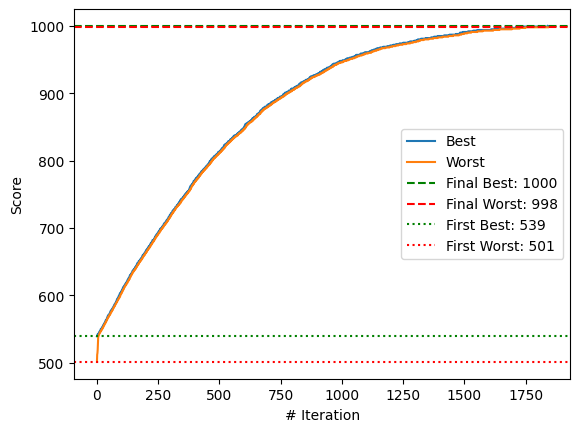

In [22]:
om = OneMax(dim=1000, population_size=40, optimize=False, has_heuristic=False)
om.iterate(2100, VariationOperator.MUTATION)
om.plot_results()